In [ ]:
# LIBRERIAS E INSTALACIONES QUE NO TENIA (CREO QUE NO ES NECESARIO QUE LO CORRAN)
pkgs = {
    "matplotlib":       "matplotlib",
    "numpy":            "numpy",
    "pandas":           "pandas",
    "scipy":            "scipy",
    "skimage":          "scikit-image",   # el módulo es skimage, pero pip lo llama scikit-image
    "histomicstk":      "histomicstk",
    "openslide":        "openslide-python"
}

import importlib, subprocess, sys

for module_name, pip_name in pkgs.items():
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"→ Instalando `{pip_name}` para poder usar `import {module_name}`…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        # tras instalar, volvemos a importar
        importlib.import_module(module_name)



→ Instalando `matplotlib` para poder usar `import matplotlib`…
→ Instalando `pandas` para poder usar `import pandas`…
→ Instalando `scipy` para poder usar `import scipy`…
→ Instalando `scikit-image` para poder usar `import skimage`…
→ Instalando `histomicstk` para poder usar `import histomicstk`…


In [ ]:
#LIBRERIAS 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import histomicstk as htk
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, dilation
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from skimage.measure import regionprops_table

Matplotlib is building the font cache; this may take a moment.


In [ ]:
#DE RGB-->OD
import numpy as np
import cv2
import matplotlib.pyplot as plt

def rgb2od(img_rgb):
    """
    Convierte una imagen RGB (0–255) a absorbancia (densidad óptica).
    """
    # convertir a float, evitar log(0) sumando 1, normalizar /256
    img = img_rgb.astype(np.float32) + 1.0
    od = -np.log10(img / 256.0)
    return od


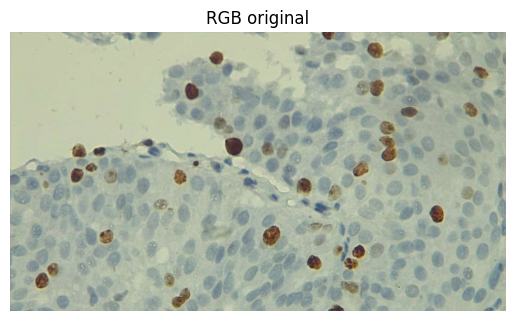

In [ ]:
# CARGAR LA IMAGEN 
ruta = r"G:\Mi unidad\Niki Facultad\DIGPATHO\EZE004 (5) (1).jpg"#--> PONER LA DIRECCION DE DONDE TIENEN GUARDADA LA IMAGEN 
rgb = cv2.imread(ruta)           # OpenCV carga en BGR
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  # convertimos a RGB
plt.imshow(rgb)
plt.title("RGB original")
plt.axis("off")
plt.show()


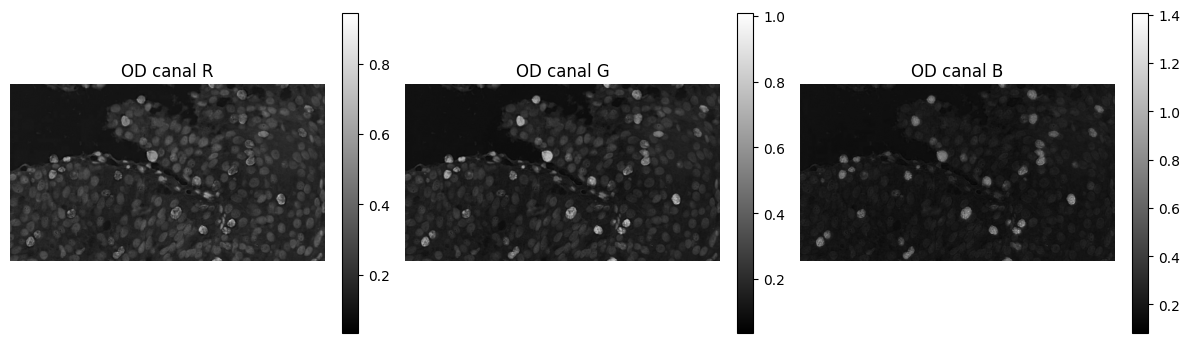

In [ ]:
#3) Convertir a Densidad Óptica
od = rgb2od(rgb)
# Visualicemos cada canal OD:
fig, axes = plt.subplots(1,3, figsize=(12,4))
for i, nombre in enumerate(["R","G","B"]):
    ax = axes[i]
    im = ax.imshow(od[:,:,i], cmap="gray")
    ax.set_title(f"OD canal {nombre}")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
#DE ACA IDENTIFIQUE QUE EL CANAL B ES EL QUE MEJOR SEPARANA LAS CELULAS 

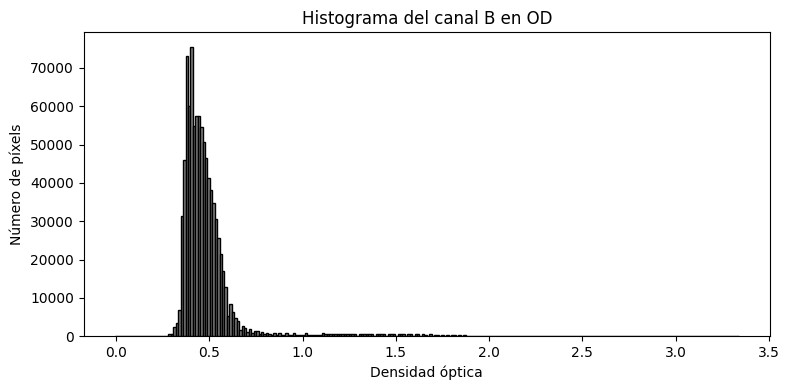

In [ ]:
#-------------HISTOGRAMA-------------------(PARTE NUEVA)
#al convertir tu imagen a densidad óptica el canal B te da dos poblaciones bien diferenciadas (positivos vs. negativos)
#vemos el histograma de ese canal 
I = rgb.astype(np.float64) / 255.0
od = -np.log(I + 1e-6)
B_od = od[:,:,2]    # tercer plano, el “canal B” en OD

hist, bins = np.histogram(B_od.ravel(), bins=256, range=(0, B_od.max()))
# lo dibujamos
plt.figure(figsize=(8,4))
plt.bar(bins[:-1], hist, width=bins[1]-bins[0], color='gray', edgecolor='black')
plt.title("Histograma del canal B en OD")
plt.xlabel("Densidad óptica")
plt.ylabel("Número de píxels")
plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define el umbral en OD (ajústalo si hace falta tras EL tu histograma)
th = 0.80#LOS VALORES QUE MAS ME GUSTARON PARA USAR SON 1.0; 0.9: 0.75

# 2) Construye la máscara booleana
mask_pos = (B_od > th)

# 3) Visualiza la máscara para comprobar que capta tus núcleos positivos
plt.figure(figsize=(6,6))
plt.imshow(mask_pos, cmap='gray')
plt.title(f"Células DAB-positivas (OD > {th})")
plt.axis('off')
plt.show()

# 4) Ahora sobrepón la máscara sobre la imagen original para ver sólo esas células
plt.figure(figsize=(6,6))
plt.imshow(rgb, alpha=0.3)            # tu RGB de fondo
plt.imshow(mask_pos, cmap='Reds',     # rojo semitransparente para el _positivo_
           alpha=0.6)                 
plt.title("Sólo DAB-positivas resaltadas")
plt.axis('off')
plt.show()
# 1) muestra la imagen original
plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.title("Imagen original")
plt.axis("off")


NameError: name 'B_od' is not defined

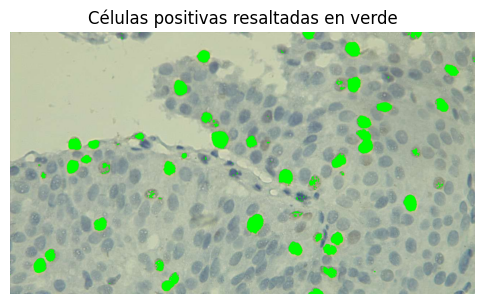

In [ ]:
#ESTA ES LA PARTE DEL CODIGO QUE HACE LA MASCARA 
import numpy as np
import matplotlib.pyplot as plt

# suponemos que ya tienes:
# rgb      : tu imagen original en uint8, rango [0–255], shape (H,W,3)
# mask_pos : tu máscara booleana, shape (H,W), True donde dab+ (positivas)

# 1) crea una copia sobre la que pintar
overlay = rgb.copy()

# 2) pinta de verde puro ([0,255,0]) todos los píxeles positivos
overlay[mask_pos] = np.array([0,255,0], dtype=np.uint8)

# 3) muéstralo
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title("Células positivas resaltadas en verde")
plt.axis("off")
plt.show()


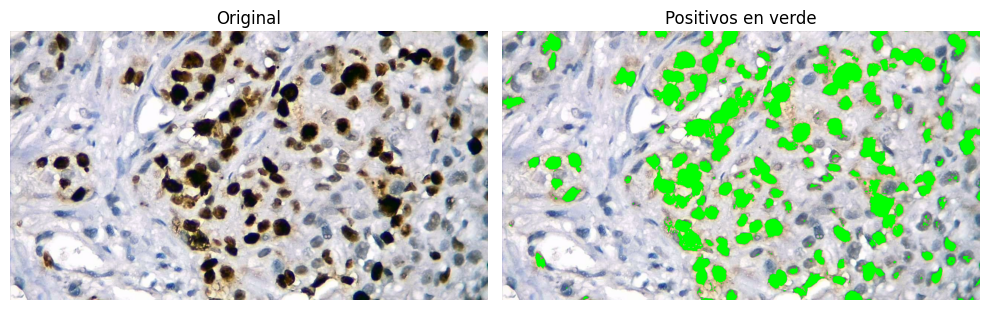

In [ ]:
#ES EL MISMO CODIGO QUE ANTES PERO TODO JUNTO PARA IR PROBANDO CON LAS OTRAS IMAGENES --> SI QUIEREN PROBAR IMAGENES SOLO CORRER ESTE 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Ruta de tu imagen
ruta = r"G:\Mi unidad\Niki Facultad\DIGPATHO\EZE007 (12)_EQ (1).jpg"

# 2) Cargo y convierto de BGR (OpenCV) a RGB
bgr = cv2.imread(ruta)
if bgr is None:
    raise FileNotFoundError(f"No se encontró el archivo: {ruta}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# 3) Paso a densidad óptica (OD)
I = rgb.astype(np.float64) / 255.0
od = -np.log(I + 1e-6)

# 4) Extraigo el canal “B” de OD
B_od = od[:, :, 2]

# 5) Creo la máscara de positivos según el umbral que vimos en el histograma
threshold = 0.85    # ajústalo si quieres más o menos restrictivo
mask = B_od > threshold

# 6) Pinto de verde (RGB = [0,255,0]) todos los píxeles positivos
overlay = rgb.copy()
overlay[mask] = np.array([0, 255, 0], dtype=np.uint8)

# 7) Muestro lado a lado el original y el overlay
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Positivos en verde")
plt.axis("off")

plt.tight_layout()
plt.show()


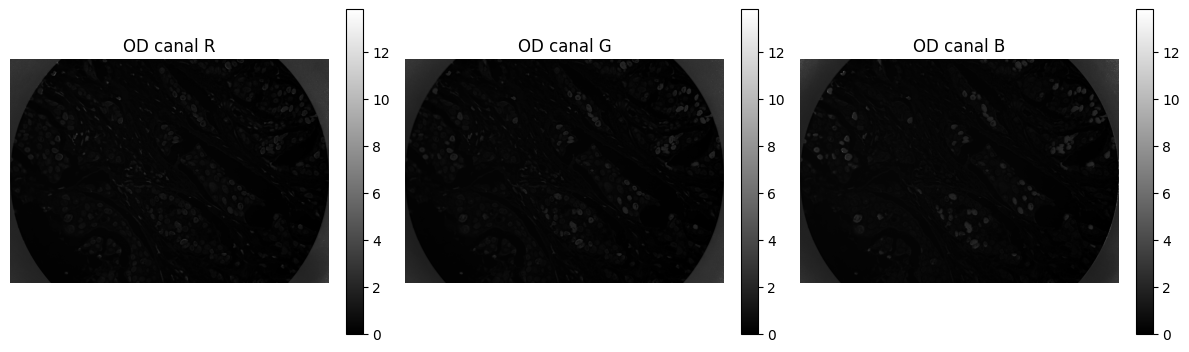

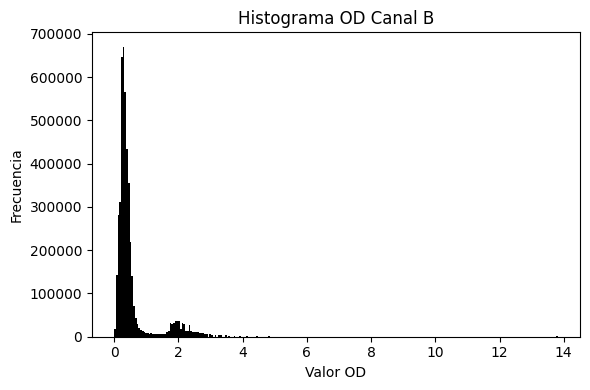

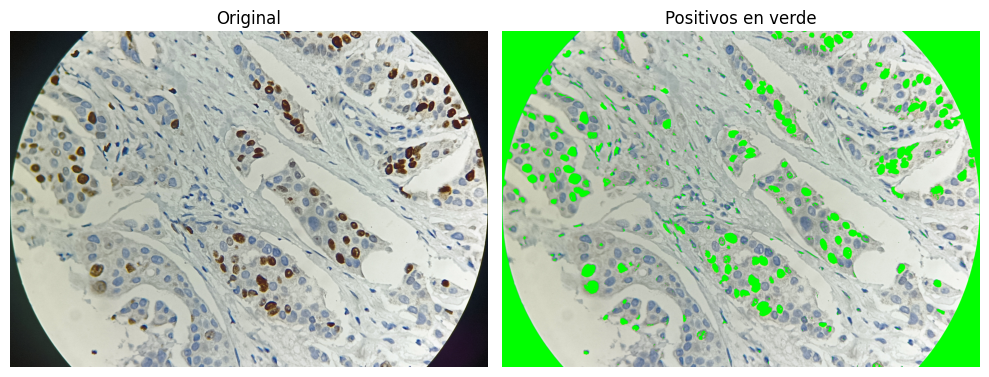

In [ ]:
##ES EL MISMO CODIGO QUE ANTES PERO TODO JUNTO Y CON LAS IMAGENES DE ISTOGRAMA POR SI HAY QUE ELEGIR OTRO HUMBRA PARA IR PROBANDO CON LAS OTRAS IMAGENES 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Ruta de tu imagen
ruta = r"G:\Mi unidad\Niki Facultad\DIGPATHO\Ki67-400x-01 E Vogel (3) (1).jpg"

# 2) Cargo y convierto de BGR (OpenCV) a RGB
bgr = cv2.imread(ruta)
if bgr is None:
    raise FileNotFoundError(f"No se encontró el archivo: {ruta}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# 3) Paso a densidad óptica (OD)
I = rgb.astype(np.float64) / 255.0
od = -np.log(I + 1e-6)

# Visualicemos cada canal OD:
fig, axes = plt.subplots(1,3, figsize=(12,4))
for i, nombre in enumerate(["R","G","B"]):
    ax = axes[i]
    im = ax.imshow(od[:,:,i], cmap="gray")
    ax.set_title(f"OD canal {nombre}")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
## 3.5) Histograma del canal B en OD (¡nuevo!)
B_od = od[:, :, 2]
plt.figure(figsize=(6, 4))
plt.hist(B_od.ravel(), bins=256, range=(B_od.min(), B_od.max()), color='black')
plt.title("Histograma OD Canal B")
plt.xlabel("Valor OD")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 4) Extraigo el canal “B” de OD
B_od = od[:, :, 2]

# 5) Creo la máscara de positivos según el umbral que vimos en el histograma
threshold = 0.75    # ajústalo si quieres más o menos restrictivo
mask = B_od > threshold

# 6) Pinto de verde (RGB = [0,255,0]) todos los píxeles positivos
overlay = rgb.copy()
overlay[mask] = np.array([0, 255, 0], dtype=np.uint8)

# 7) Muestro lado a lado el original y el overlay
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Positivos en verde")
plt.axis("off")

plt.tight_layout()
plt.show()